In [1]:
from compute import Var, Par, ureg
from modeling.api import Model, adda, addsolver,evalexpr
import sympy as sp
import numpy as np
from graph.matrixview import render_incidence
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [2]:
ureg.define('percent = 0.01')
length_of_cabin = Par('L', 2, 'm')
hydraulic_diameter_cabin = Par('D', 2, 'm')
distance_between_people = Par('d', 1, 'm')
lung_capacity = Par('C', 5e-4, 'm^3')
breathing_rate = Par('r', 16, '1/min')
mean_air_velocity = Par('v', 1e-12, 'm/s')
diameter_of_person = Par('DP', 0.1, 'm')
mask_efficiency = Par(r'\eta_m', 0.5)
mask_multiplier = (1-mask_efficiency)**2
virions_generation = Par('g', 300, '1/min')
time_of_exposure = Par('T', 30, 'min')
num_virions_to_infect = Par('N', 1000, '')
total_filter_efficiency = Var(r'\eta', 0.8)
volumetric_flow = Var('Q', 0.0005, 'm^3/s')

In [31]:
model = Model()
m = model.root
volume_cabin = adda(m, 'V', length_of_cabin*np.pi*hydraulic_diameter_cabin**2/4, 'ft^3')
ACH = adda(m, 'A', volumetric_flow/volume_cabin, '1/hr')
diffusivity = adda(m, 'k', 0.005*(ACH*3600)**0.6, 'm^2/s', forceunit=True)
exponent = adda(m, 'e', mean_air_velocity/diffusivity, '1/m')
meter = Par('m', 1, 'm')
volumetric_diffusion_rate = adda(m, 'Qd', 0.3*diffusivity*np.pi*length_of_cabin/diameter_of_person*meter, 'm^3/min')
virions_concentration = adda(m, 'c_v', virions_generation/volumetric_diffusion_rate)
concentration_out = adda(m, 'c_o', virions_generation/(total_filter_efficiency*volumetric_flow))
c_s = adda(m, 'c_s', virions_concentration+concentration_out)
A_coeff = adda(m, 'A_c', virions_concentration/((hydraulic_diameter_cabin/(2*meter))**(exponent*meter)+(diameter_of_person/(2*meter))**(exponent*meter)))
B_coeff = adda(m, 'B_c', c_s-A_coeff*(diameter_of_person/(2*meter))**(exponent*meter))
c_x = adda(m, 'c_x', A_coeff*distance_between_people/meter**(exponent*meter)+B_coeff)
virions_per_breath = adda(m, 'R_v', c_x*lung_capacity)
virions_per_minute = adda(m, 'r_v', virions_per_breath*breathing_rate, '1/min')
virions_total = adda(m, 'v_t', virions_per_minute*time_of_exposure)
virions_inhaled_total_masked = adda(m, 'v_T', virions_total*mask_multiplier)
p_of_infection = adda(m, 'P', 1-sp.exp(-virions_inhaled_total_masked/num_virions_to_infect), unit='percent')


In [32]:
total_filter_efficiency

\eta

In [33]:
p_of_infection

P

In [14]:
from modeling.api import edges_no_param
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)

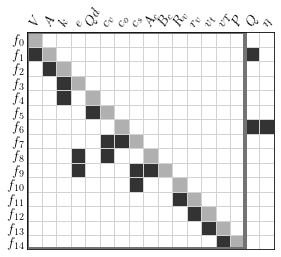

In [15]:
render_incidence(edges_nopar, tree, hideticks=True, rawvarname=True, patchwidth=4, fontsize=14);

In [16]:
from solver.runpipeline import model_to_problem
solvers_options = model.solvers_options
solvers_options['root'] = {'solver': 'N', 'maxiter':20, 'iprint': 0}
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges, tree),
                        components=model.components)
prob.model.linear_solver.options['iprint']=0
prob.model.nonlinear_solver.options['iprint']=0

In [59]:
prob.set_val('eta', 0.7612244897959183)
prob.set_val('Q', 0.0005)

In [60]:
prob.run_model()


==
s1
==
NL: Newton Converged in 0 iterations


In [61]:
prob.model.get_val('P')

array([8.20013521])

In [ ]:
import openmdao.api as om
prob.model.add_design_var('eta', lower=0.7, upper=1)
prob.model.add_design_var('Q', lower=1e-4, upper=1e-2)
prob.model.add_objective('P')

prob.driver = om.DOEDriver(om.UniformGenerator(num_samples=1000))
prob.driver.add_recorder(om.SqliteRecorder("cases.sql"))
prob.setup()

prob.run_driver()
prob.cleanup()

cr = om.CaseReader("cases.sql")
cases = cr.list_cases('driver')

In [10]:
values = []
for case in cases:
    outputs = cr.get_case(case).outputs
    values.append((outputs['eta'], outputs['Q'], outputs['P']))

In [11]:
X, Y,Z = np.array(values).T[0]

In [17]:
def run_once(x,y):
    prob.set_val('eta',x)
    prob.set_val('Q',y)
    prob.run_model()
    P = prob.get_val('P')
    return P[0]
vfunc = np.vectorize(run_once)

In [21]:
import scipy
XX,YY = np.meshgrid(np.linspace(0.7, 1,50), 
    np.linspace(1e-3, 1e-2,50))
#Zgrid = scipy.interpolate.griddata((X,Y),Z, (XX, YY))
ZZ = vfunc(XX,YY)


==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL: Newton Converged in 0 iterations

==
s1
==
NL:

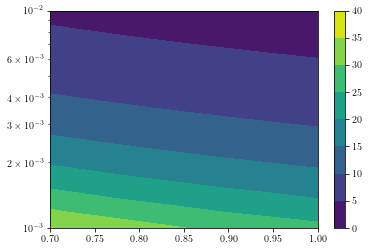

In [23]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(XX, YY, ZZ)
ax.set_yscale('log')
fig.colorbar(cp)

In [25]:
XX[25,10], YY[25,10], ZZ[25,10]

(0.7612244897959183, 0.005591836734693878, 6.952580693938281)